<a href="https://colab.research.google.com/github/ontenkutsenko/DL_Skin_Disease_Classification/blob/main/3.%20Final%20model%20experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow_addons

import tensorflow_addons as tfa

import pickle

import pandas as pd
import numpy as np
import os
import requests
from tqdm import tqdm
import shutil

from tensorflow.keras.applications import ResNet50, VGG16, VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import Callback

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l2

from collections import Counter

from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
import matplotlib.pyplot as plt
import IPython
import time

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 1.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


#### Importing the data

In [ ]:
!gdown 1C8m64W-Tv5R0VJHUtkUXOVt8wZi1coXc

Downloading...
From (original): https://drive.google.com/uc?id=1C8m64W-Tv5R0VJHUtkUXOVt8wZi1coXc
From (redirected): https://drive.google.com/uc?id=1C8m64W-Tv5R0VJHUtkUXOVt8wZi1coXc&confirm=t&uuid=7f2ce4ee-afa1-4d76-b579-a9b278d813ea
To: /content/Images for project.zip
100% 1.42G/1.42G [00:15<00:00, 90.7MB/s]


In [ ]:
!unzip -q "/content/Images for project.zip" -d /content/

In [ ]:
!rm '/content/Images for project.zip'

#### Sorting the images into separate train-val-test folders

In [ ]:
url = 'https://raw.githubusercontent.com/ontenkutsenko/DL_Skin_Desease_Classification/main/Data/fitzpatrick17k.csv'
df = pd.read_csv(url).dropna(subset = ['url'])
df = df.sample(frac=1, random_state=10).reset_index(drop=True)

Our dataset contains information of skin color, which may be really important in case of Computer Vision task. We don't want our model to be biased, so we will stratify data in train, validation and test not only by label, but by every skin color, using fitzpatrick_scale. It will help to achieve better generalization and make validation stage more reliable

In [ ]:
df['rank'] = df.groupby(['label', 'fitzpatrick_scale']).cumcount()/(df.groupby(['label', 'fitzpatrick_scale']).transform('count')['url'] - 1)

In [ ]:
def assign_split(row, proportion):
    if row['rank'] < proportion['train']:
        return 'train'
    elif row['rank'] < proportion['train']+proportion['test']:
        return 'test'
    else:
        return 'val'

In [ ]:

proportion = {
    'train': 0.70,
    'val': 0.10,
    'test': 0.20
}

df['split'] = df.apply(lambda row: assign_split(row, proportion), axis=1)
df.split.value_counts()/len(df)

split
train    0.687712
test     0.188800
val      0.123488
Name: count, dtype: float64

In [ ]:
shutil.rmtree('/content/dataset', ignore_errors=True)

source_folder = '/content/Images for project'
destination_folder = '/content/dataset'


for i in range(len(df)):
  try:
    source_file = os.path.join(source_folder, df['url'][i].split('/')[-1])
    destination_file = os.path.join(destination_folder, df['split'][i], df['label'][i], f"{df['url'][i].split('/')[-1]}.jpg")
    os.makedirs(os.path.dirname(destination_file), exist_ok=True)

    shutil.move(source_file, destination_file)
  except:
    print(source_file, ' doesn\'t exist')

/content/Images for project/img?imageId=4030  doesn't exist
/content/Images for project/img?imageId=8364  doesn't exist
/content/Images for project/img?imageId=2767  doesn't exist
/content/Images for project/img?imageId=4031  doesn't exist
/content/Images for project/img?imageId=5399  doesn't exist
/content/Images for project/img?imageId=2766  doesn't exist
/content/Images for project/img?imageId=6724  doesn't exist
/content/Images for project/img?imageId=4505  doesn't exist
/content/Images for project/img?imageId=8362  doesn't exist
/content/Images for project/img?imageId=8363  doesn't exist


#### Define Data Generators (Rest comes when we compile and train)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    brightness_range=(0.7, 1.3),
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

#### Creating Callbacks

In [ ]:
# As skin disease task might be very complex we want to measure simple accuracy
# But Top_n accuracy (meaning we check if there is correct prediction among top N predictions we make)

def top_n_accuracy(y_val, val_predictions, n):
  diff = np.min(np.abs(np.argsort(y_val, axis = 1)[:,-1:] - np.argsort(val_predictions, axis=1)[:,-n:]), axis = 1)
  return np.count_nonzero(diff == 0)/len(diff)


class TopNAccuracyCallback(Callback):
  def __init__(self, val_generator):
      super().__init__()
      self.val_generator = val_generator

  def on_epoch_end(self, epoch, logs=None):
      start_time = time.time()
      top_1_acc = []
      top_3_acc = []
      top_5_acc = []
      for x_val_batch, y_val_batch in self.val_generator:
        val_predictions = self.model.predict(x_val_batch, verbose = 0)
        top_1_acc.append(top_n_accuracy(y_val_batch, val_predictions, 1))
        top_3_acc.append(top_n_accuracy(y_val_batch, val_predictions, 3))
        top_5_acc.append(top_n_accuracy(y_val_batch, val_predictions, 5))
        if len(top_1_acc) >= len(self.val_generator):
          break
      end_time = time.time()
      duration = end_time - start_time
      print(f'Top-1 accuracy: {np.mean(top_1_acc):.3f}, Top-3 accuracy: {np.mean(top_3_acc):.3f}, Top-5 accuracy: {np.mean(top_5_acc):.3f}, \nTime to calculate: {duration:.2f} seconds')

In [ ]:
class PlotMetricsCallback(Callback):
    def on_train_begin(self, logs=None):
        self.losses = []
        self.val_losses = []
        self.accuracies = []
        self.val_accuracies = []
        self.weighted_f1 = []
        self.val_weighted_f1 = []

    def on_epoch_end(self, epoch, logs):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracies.append(logs.get('accuracy'))
        self.val_accuracies.append(logs.get('val_accuracy'))
        self.weighted_f1.append(logs.get('weighted_f1'))
        self.val_weighted_f1.append(logs.get('val_weighted_f1'))

        plt.figure(figsize=(18, 5))

        plt.subplot(1, 3, 1)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.plot(range(1, epoch + 2), self.losses, label='Training Loss', color='blue', linestyle='-')
        plt.plot(range(1, epoch + 2), self.val_losses, label='Validation Loss', color='red', linestyle='-.')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.plot(range(1, epoch + 2), self.accuracies, label='Training Accuracy', color='blue', linestyle='-')
        plt.plot(range(1, epoch + 2), self.val_accuracies, label='Validation Accuracy', color='red', linestyle='-.')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()

        plt.subplot(1, 3, 3)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.plot(range(1, epoch + 2), self.weighted_f1, label='Training Weighted F1', color='blue', linestyle='-')
        plt.plot(range(1, epoch + 2), self.val_weighted_f1, label='Validation Weighted F1', color='red', linestyle='-.')
        plt.xlabel('Epochs')
        plt.ylabel('Weighted F1')
        plt.title('Training and Validation Weighted F1')
        plt.legend()

        plt.tight_layout()
        plt.show()

# To plot metrics every epoch
plot_metrics_callback = PlotMetricsCallback()

In [ ]:
# define here also metric of f1 weighted and macro
weighted_f1_score = tfa.metrics.F1Score(num_classes=114, average = 'weighted', name = 'weighted_f1')
macro_f1_score = tfa.metrics.F1Score(num_classes=114, average = 'macro', name = 'macro_f1')

In [ ]:
# Creatings instances

# To stop training if validation loss stops improving
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

# To save weights of the model with best accuracy
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

# To reduce learning rate if validation loss do not improve several epochs
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# To clear plot every epoch
clear_output_callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs: IPython.display.clear_output(wait=True)
)






#### Creating the Model




In [ ]:
# reusable function

def compile_and_train_model(optimizer, batch_size=128, epochs=30, use_class_weights=False, input_size = (128,128)):

    # Instance of our pretrained model we will use
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_size + (3,))
    # only the top layers of the base model will be trainable
    for layer in base_model.layers[:-4]:
        layer.trainable = False

    train_generator = train_datagen.flow_from_directory(
        'dataset/train',
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical',
        target_size=input_size)

    val_generator = val_datagen.flow_from_directory(
        'dataset/val',
        batch_size=batch_size,
        class_mode='categorical',
        target_size=input_size)

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu',
                     kernel_regularizer=l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(114, activation='softmax')
    ])

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy', weighted_f1_score, macro_f1_score])

    # instance for top_n_accuracy
    top_n_accuracy_callback = TopNAccuracyCallback(val_generator)

    callbacks = [reduce_lr, early_stopping, model_checkpoint, clear_output_callback, plot_metrics_callback, top_n_accuracy_callback]

    if use_class_weights:
        class_weights = dict(enumerate(compute_class_weight('balanced',
                                                            classes=np.unique(train_generator.classes),
                                                            y=train_generator.classes)))
        history = model.fit(train_generator,
                            validation_data=val_generator,
                            epochs=epochs,
                            steps_per_epoch=len(train_generator),
                            validation_steps=len(val_generator),
                            class_weight=class_weights,
                            callbacks=callbacks,
                            verbose=1)
    else:
        history = model.fit(train_generator,
                            validation_data=val_generator,
                            epochs=epochs,
                            steps_per_epoch=len(train_generator),
                            validation_steps=len(val_generator),
                            callbacks=callbacks, verbose=1)

    return model, history

In [ ]:
#Function to compare covergence with different parameters

def plot_comparison(history, labels):
  val_accuracies = []
  for i in history:
      val_accuracies.append(i['val_accuracy'])

  plt.figure(figsize=(16, 5))
  for j in range(len(val_accuracies)):
      plt.subplot(1, 2, 1)
      plt.plot(range(1, len(val_accuracies[j]) + 1), val_accuracies[j], label=labels[j],  linestyle='-')

  plt.grid(True, linestyle='--', alpha=0.7)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Validation Accuracy')
  plt.legend()

  val_f1 = []
  for i in history:
      val_f1.append(i['val_weighted_f1'])

  for j in range(len(val_f1)):
      plt.subplot(1, 2, 2)
      plt.plot(range(1, len(val_f1[j]) + 1), val_f1[j], label=labels[j],  linestyle='-')

  plt.subplot(1, 2, 2)
  plt.grid(True, linestyle='--', alpha=0.7)
  plt.xlabel('Epochs')
  plt.ylabel('Weighted F1')
  plt.title('Validation Weighted F1')
  plt.legend()
  plt.show()

#### Let's compare different optimizers

In [ ]:
sgd_optimizer = SGD(lr=0.001, momentum=0.9)
adam_optimizer = Adam(learning_rate=0.001)

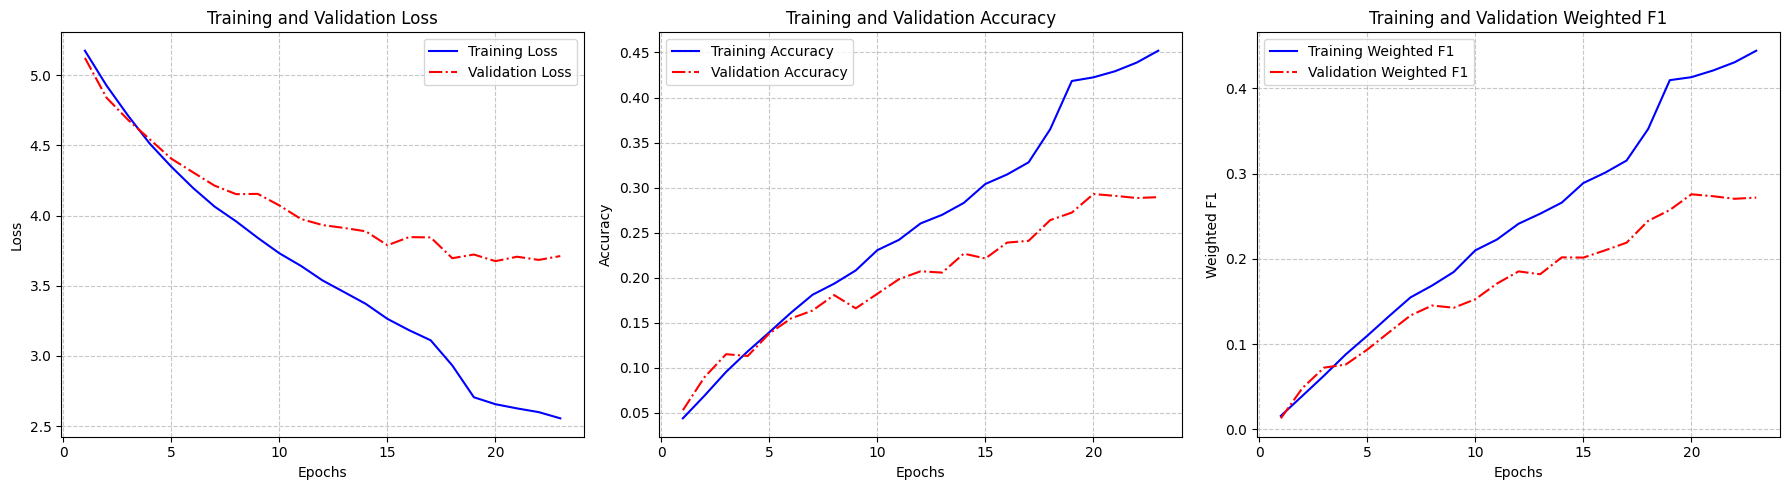

Top-1 accuracy: 0.293, Top-3 accuracy: 0.437, Top-5 accuracy: 0.530, 
Time to calculate: 12.82 seconds
89/89 [==============================] - 123s 1s/step - loss: 2.5556 - accuracy: 0.4520 - weighted_f1: 0.4441 - macro_f1: 0.4273 - val_loss: 3.7112 - val_accuracy: 0.2894 - val_weighted_f1: 0.2718 - val_macro_f1: 0.2540 - lr: 1.0000e-04


In [ ]:
model_sgd, history_sgd = compile_and_train_model(sgd_optimizer, batch_size=128, epochs=30)


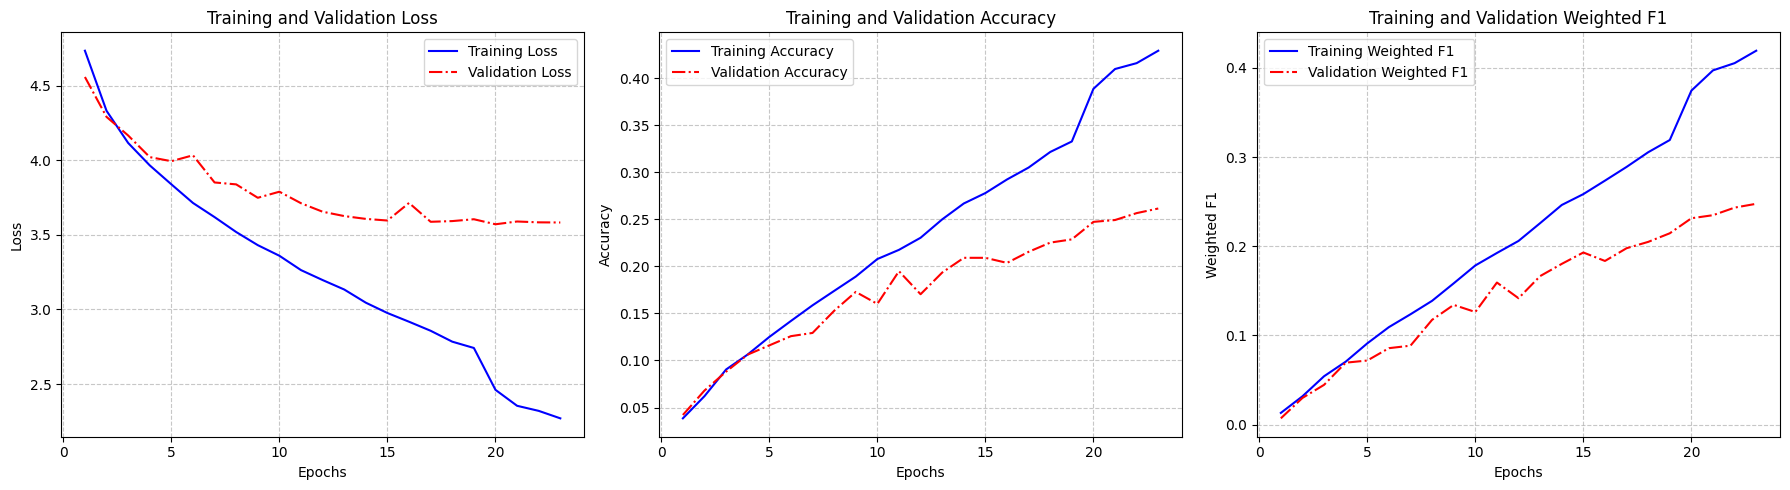

Top-1 accuracy: 0.247, Top-3 accuracy: 0.402, Top-5 accuracy: 0.500, 
Time to calculate: 12.79 seconds
89/89 [==============================] - 122s 1s/step - loss: 2.2700 - accuracy: 0.4292 - weighted_f1: 0.4193 - macro_f1: 0.4022 - val_loss: 3.5835 - val_accuracy: 0.2615 - val_weighted_f1: 0.2477 - val_macro_f1: 0.2294 - lr: 1.0000e-05


In [ ]:
model_adam, history_adam = compile_and_train_model(adam_optimizer, batch_size=128, epochs=30)

#### Let's compare different batch sizes

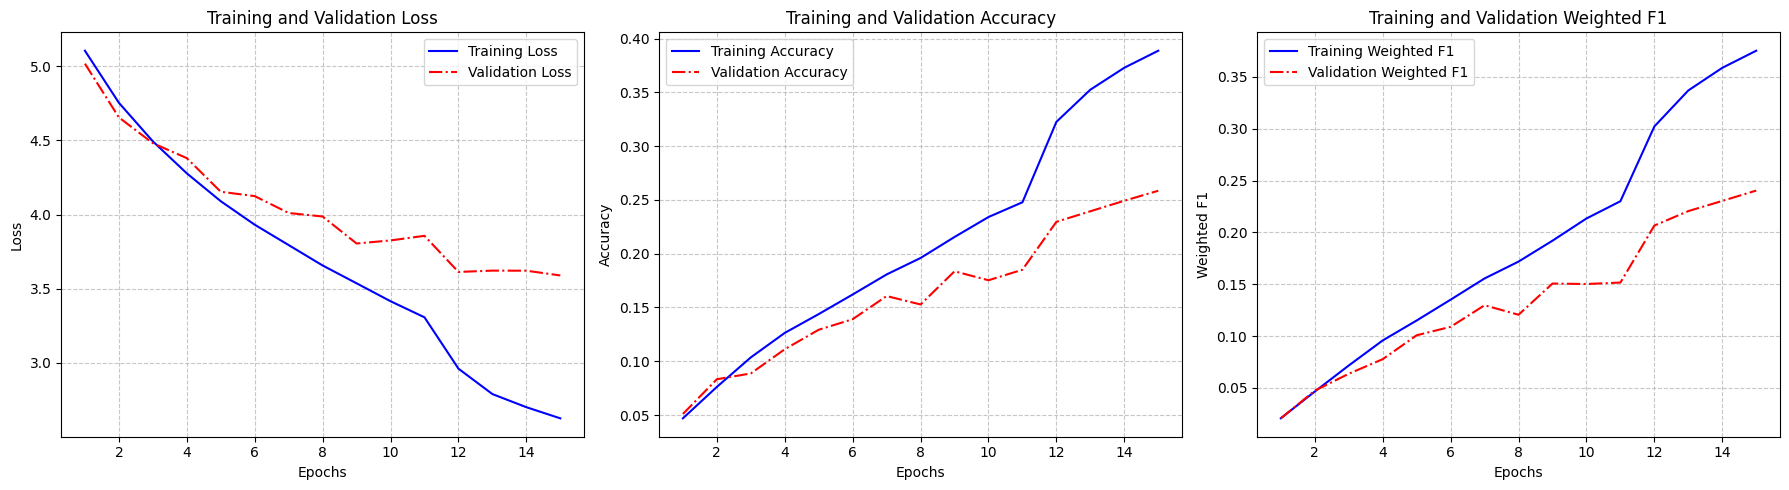

Top-1 accuracy: 0.259, Top-3 accuracy: 0.415, Top-5 accuracy: 0.511, 
Time to calculate: 15.68 seconds
356/356 [==============================] - 135s 379ms/step - loss: 2.6241 - accuracy: 0.3888 - weighted_f1: 0.3753 - macro_f1: 0.3515 - val_loss: 3.5886 - val_accuracy: 0.2586 - val_weighted_f1: 0.2404 - val_macro_f1: 0.2218 - lr: 1.0000e-04


In [ ]:
sgd_optimizer = SGD(lr=0.001, momentum=0.9)
model_batch_32, history_batch_32 = compile_and_train_model(sgd_optimizer, batch_size=32, epochs=15)

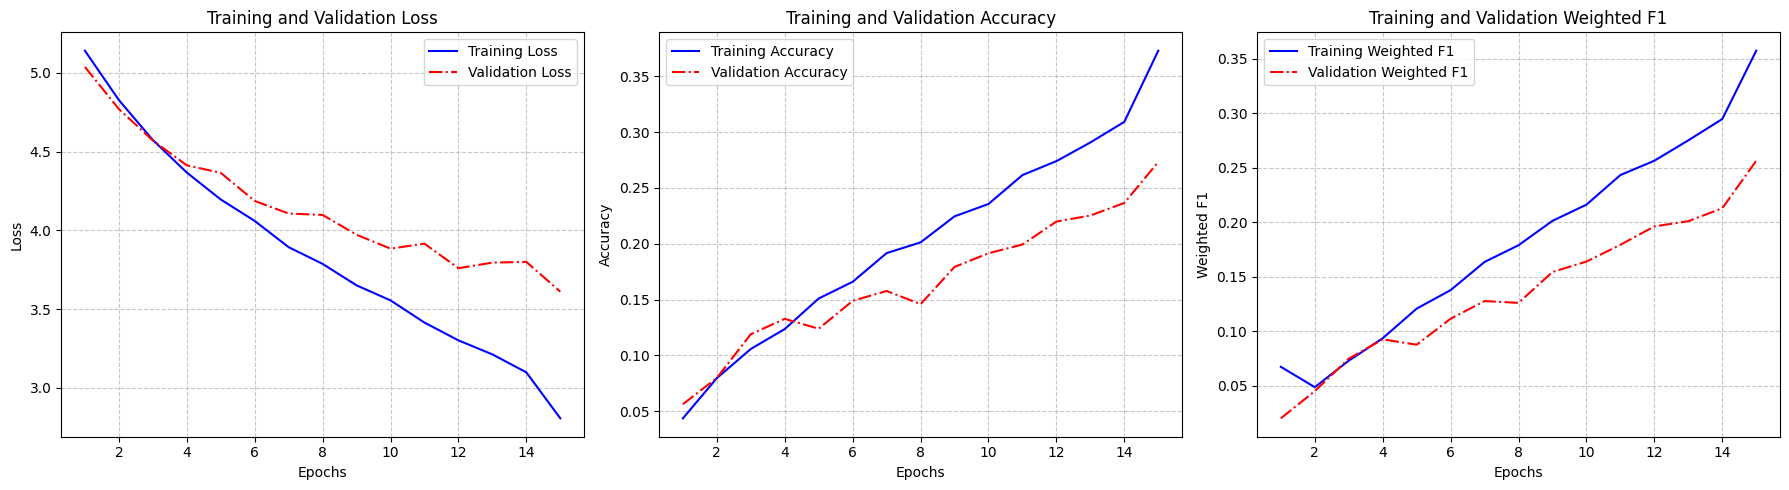

Top-1 accuracy: 0.273, Top-3 accuracy: 0.431, Top-5 accuracy: 0.521, 
Time to calculate: 13.62 seconds
178/178 [==============================] - 126s 706ms/step - loss: 2.8072 - accuracy: 0.3729 - weighted_f1: 0.3576 - macro_f1: 0.3354 - val_loss: 3.6114 - val_accuracy: 0.2733 - val_weighted_f1: 0.2566 - val_macro_f1: 0.2419 - lr: 1.0000e-03


In [ ]:
sgd_optimizer = SGD(lr=0.001, momentum=0.9)
model_batch_64, history_batch_64 = compile_and_train_model(sgd_optimizer, batch_size=64, epochs=15)

In [ ]:
model_batch_64.save_weights('/content/weights_model_batch_64.h5')

In [ ]:
import pickle

history_data = history_batch_32.history

file_path = "/content/history_batch_32.pkl"

with open(file_path, "wb") as pickle_file:
    pickle.dump(history_data, pickle_file)


History data saved to pickle successfully.


In [ ]:
import pickle

file_path = "/content/history_batch_32.pkl"

with open(file_path, "rb") as pickle_file:
    loaded_data = pickle.load(pickle_file)

loaded_data

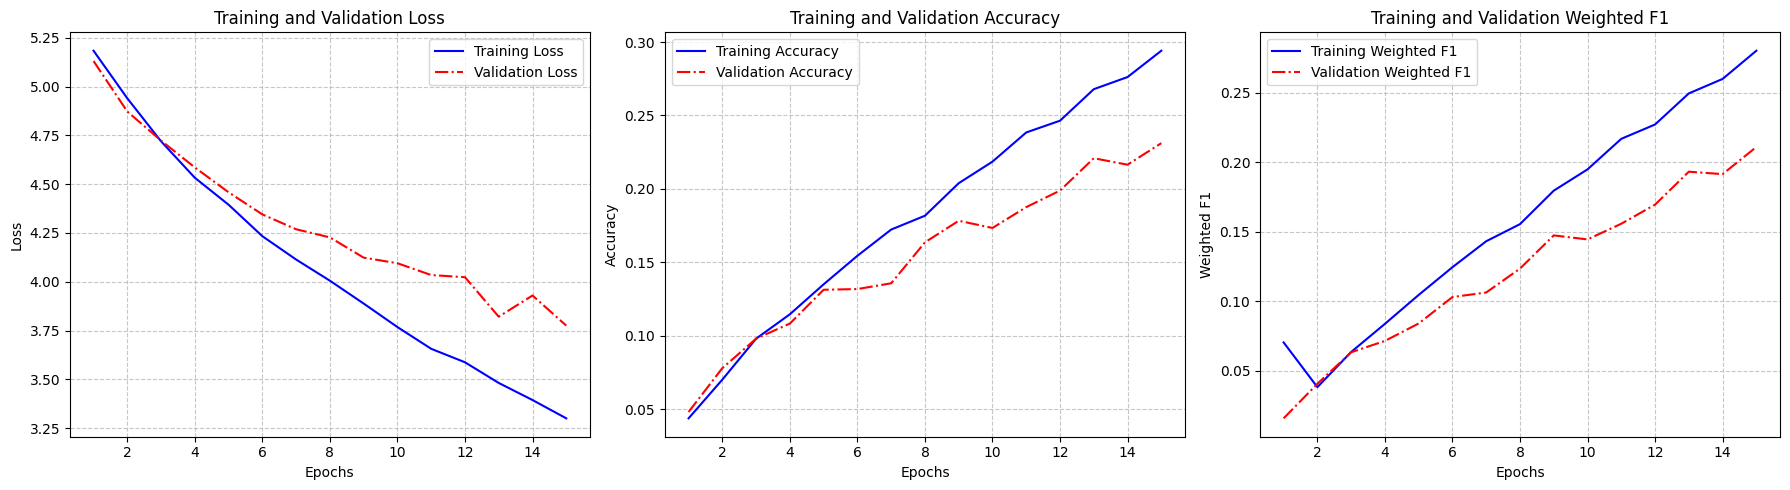

Top-1 accuracy: 0.231, Top-3 accuracy: 0.390, Top-5 accuracy: 0.484, 
Time to calculate: 13.02 seconds
89/89 [==============================] - 126s 1s/step - loss: 3.3000 - accuracy: 0.2941 - weighted_f1: 0.2802 - macro_f1: 0.2547 - val_loss: 3.7751 - val_accuracy: 0.2311 - val_weighted_f1: 0.2110 - val_macro_f1: 0.1882 - lr: 0.0100


In [ ]:
sgd_optimizer = SGD(lr=0.001, momentum=0.9)
model_batch_128, history_batch_128 = compile_and_train_model(sgd_optimizer, batch_size=128, epochs=15)

In [ ]:
import pickle

history_data = history_batch_128.history

file_path = "/content/history_batch_128.pkl"

with open(file_path, "wb") as pickle_file:
    pickle.dump(history_data, pickle_file)

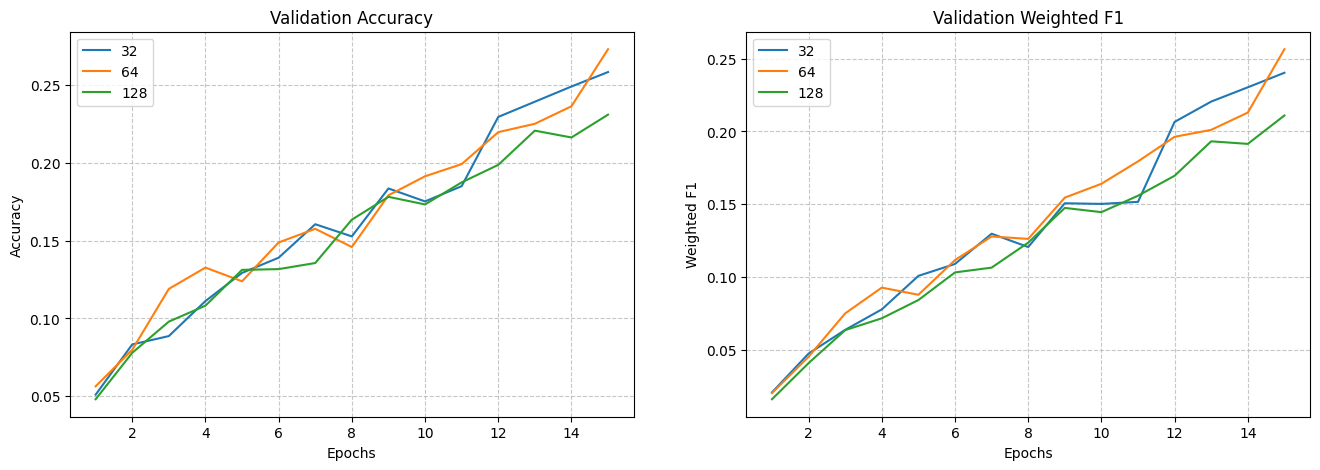

In [ ]:
history = [history_batch_32.history, history_batch_64.history, history_batch_128.history]
labels = ['32', '64', '128']

plot_comparison(history, labels)

#### Let's compare different image sizes

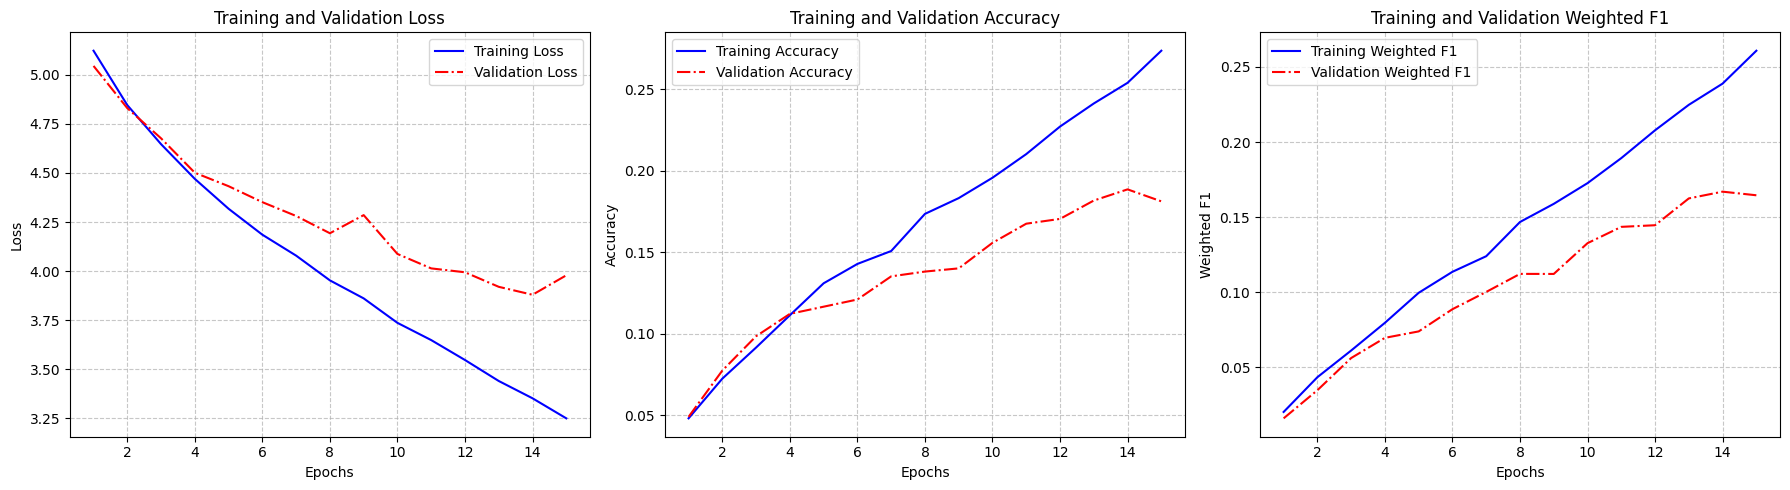

Top-1 accuracy: 0.181, Top-3 accuracy: 0.324, Top-5 accuracy: 0.423, 
Time to calculate: 11.08 seconds
178/178 [==============================] - 86s 483ms/step - loss: 3.2490 - accuracy: 0.2736 - weighted_f1: 0.2608 - macro_f1: 0.2409 - val_loss: 3.9783 - val_accuracy: 0.1812 - val_weighted_f1: 0.1646 - val_macro_f1: 0.1519 - lr: 0.0100


In [ ]:
sgd_optimizer = SGD(lr=0.001, momentum=0.9)
model_input_64, history_input_64 = compile_and_train_model(sgd_optimizer, batch_size=64, epochs=15, input_size = (64,64))

In [ ]:
history_data = history_input_64.history

file_path = "/content/history_input_64.pkl"

with open(file_path, "wb") as pickle_file:
    pickle.dump(history_data, pickle_file)

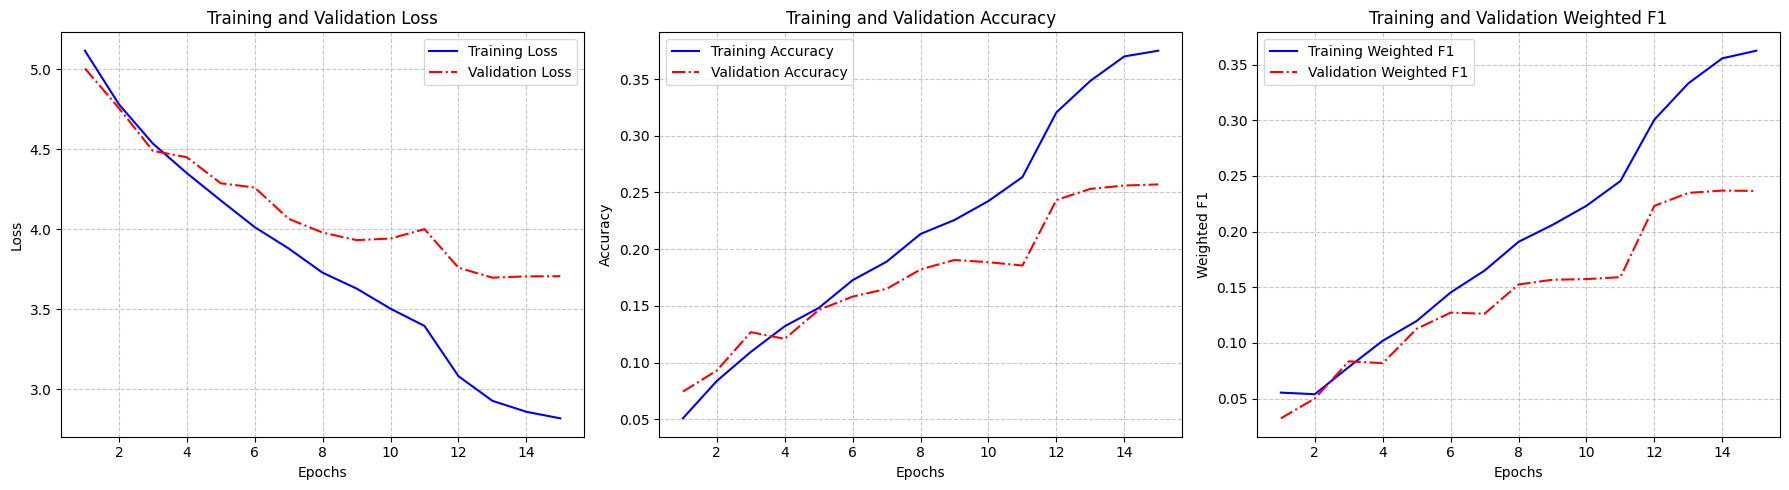

Top-1 accuracy: 0.257, Top-3 accuracy: 0.419, Top-5 accuracy: 0.499, 
Time to calculate: 14.38 seconds
178/178 [==============================] - 128s 721ms/step - loss: 2.8174 - accuracy: 0.3750 - weighted_f1: 0.3625 - macro_f1: 0.3411 - val_loss: 3.7058 - val_accuracy: 0.2571 - val_weighted_f1: 0.2366 - val_macro_f1: 0.2204 - lr: 1.0000e-03


In [ ]:
sgd_optimizer = SGD(lr=0.001, momentum=0.9)
model_input_128, history_input_128 = compile_and_train_model(sgd_optimizer, batch_size=64, epochs=15, input_size = (128, 128))

In [ ]:
history_data = history_input_128.history

file_path = "/content/history_input_128.pkl"

with open(file_path, "wb") as pickle_file:
    pickle.dump(history_data, pickle_file)

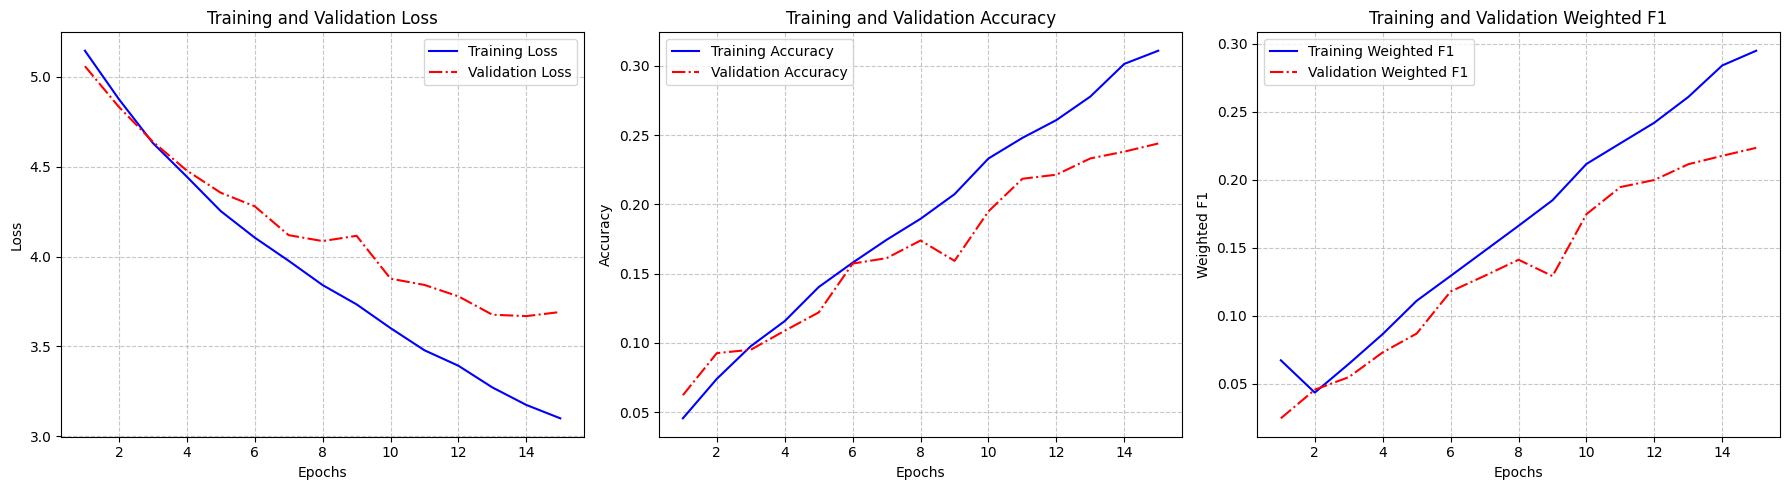

Top-1 accuracy: 0.244, Top-3 accuracy: 0.412, Top-5 accuracy: 0.489, 
Time to calculate: 22.10 seconds
178/178 [==============================] - 268s 2s/step - loss: 3.0990 - accuracy: 0.3108 - weighted_f1: 0.2949 - macro_f1: 0.2640 - val_loss: 3.6911 - val_accuracy: 0.2439 - val_weighted_f1: 0.2235 - val_macro_f1: 0.2043 - lr: 0.0100


In [ ]:
sgd_optimizer = SGD(lr=0.001, momentum=0.9)
model_input_224, history_input_224 = compile_and_train_model(sgd_optimizer, batch_size=64, epochs=15, input_size = (224,224))

In [ ]:
history_data = history_input_224.history

file_path = "/content/history_input_224.pkl"

with open(file_path, "wb") as pickle_file:
    pickle.dump(history_data, pickle_file)

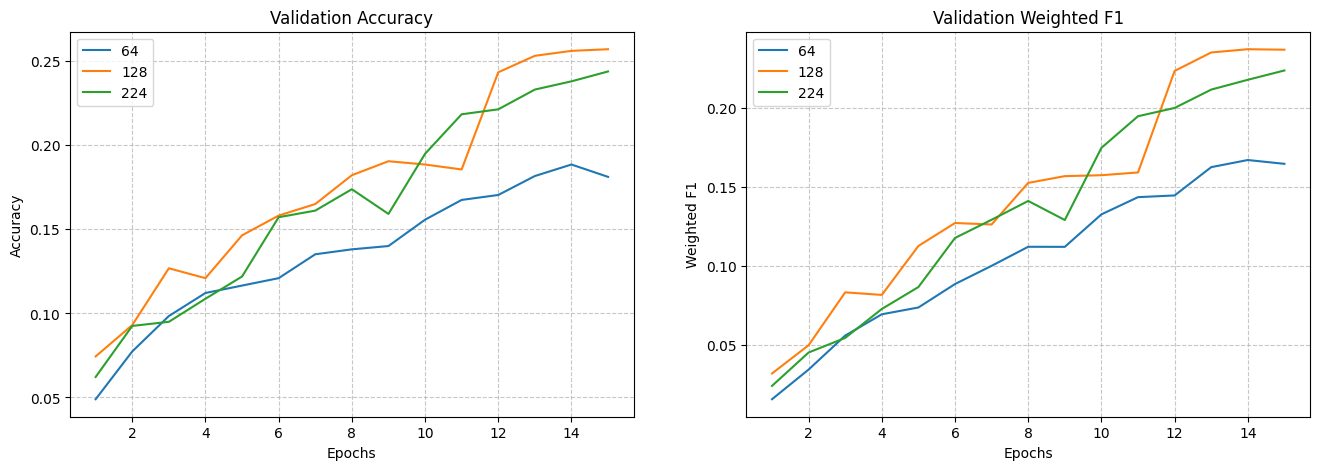

In [ ]:
history = [history_input_64.history, history_input_128.history, history_input_224.history]
labels = ['64', '128', '224']

plot_comparison(history, labels)

#### Let's try to add class weights and oversampling

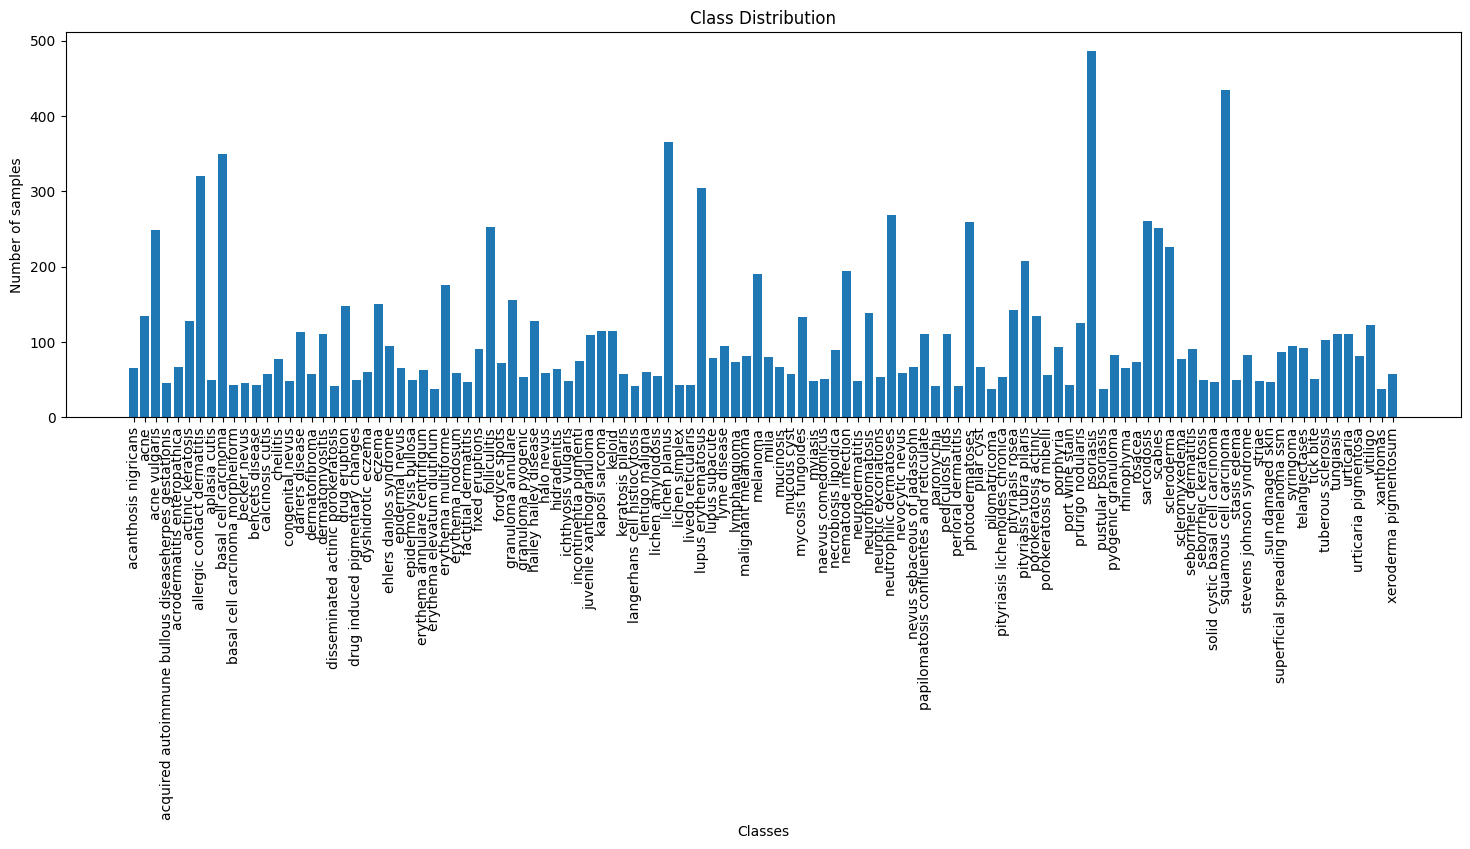

In [ ]:
# Let's visualize quickly how imbalanced our classes are
train_generator = train_datagen.flow_from_directory(
        'dataset/train',
        batch_size=32,
        shuffle=True,
        class_mode='categorical',
        target_size=(128,128,3))

class_counts = {class_label: 0 for class_label in train_generator.class_indices}

for class_index in train_generator.classes:
    class_label = [label for label, index in train_generator.class_indices.items() if index == class_index][0]
    class_counts[class_label] += 1

labels = list(class_counts.keys())
counts = [class_counts[label] for label in labels]




plt.figure(figsize=(18, 5))
plt.bar(labels, counts)
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.title('Class Distribution')
plt.xticks(rotation=90)
plt.show()

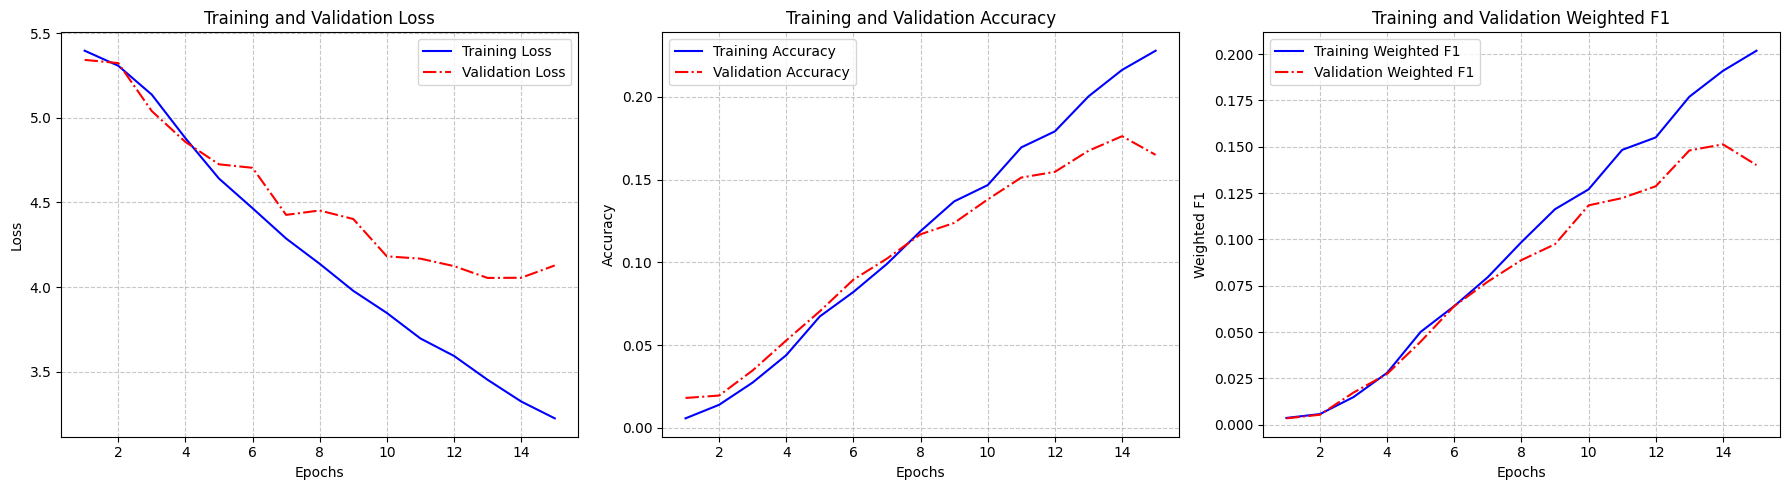

Top-1 accuracy: 0.165, Top-3 accuracy: 0.315, Top-5 accuracy: 0.396, 
Time to calculate: 14.49 seconds
178/178 [==============================] - 133s 745ms/step - loss: 3.2257 - accuracy: 0.2280 - weighted_f1: 0.2018 - macro_f1: 0.2302 - val_loss: 4.1281 - val_accuracy: 0.1650 - val_weighted_f1: 0.1401 - val_macro_f1: 0.1527 - lr: 0.0100


In [ ]:
sgd_optimizer = SGD(lr=0.001, momentum=0.9)
model_with_class_weights, history_with_class_weights = compile_and_train_model(sgd_optimizer, batch_size=64, epochs=15, use_class_weights=True)

In [ ]:
history_data = history_with_class_weights.history

file_path = "/content/history_with_class_weights.pkl"

with open(file_path, "wb") as pickle_file:
    pickle.dump(history_data, pickle_file)

In [ ]:
class CustomDirectoryIterator(DirectoryIterator):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        class_counts = Counter(self.classes)
        total_samples = sum(class_counts.values())
        self.class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
        self.sampled_classes = []

    def __next__(self):
        batch_x, batch_y = super().__next__()
        sampled_indices = np.random.choice(len(batch_x),
                                           size=len(batch_x),
                                           p=[self.class_weights[np.where(cls == 1)[0][0]] for cls in batch_y] /
                                             np.sum([self.class_weights[np.where(cls == 1)[0][0]] for cls in batch_y]))
        self.sampled_classes = np.where(batch_y[sampled_indices] == 1)[1]
        return batch_x[sampled_indices], batch_y[sampled_indices]

    def __getitem__(self, idx):
        batch_x, batch_y = super().__getitem__(idx)

        sampled_indices = np.random.choice(len(batch_x),
                                           size=len(batch_x),
                                           p=[self.class_weights[np.where(cls == 1)[0][0]] for cls in batch_y] /
                                             np.sum([self.class_weights[np.where(cls == 1)[0][0]] for cls in batch_y]))
        self.sampled_classes = np.where(batch_y[sampled_indices] == 1)[1]
        return batch_x[sampled_indices], batch_y[sampled_indices]

class OversamplingImageDataGenerator(ImageDataGenerator):
    def flow_from_directory(self, *args, **kwargs):
        return CustomDirectoryIterator(*args, image_data_generator = self, **kwargs)

In [ ]:
train_datagen = OversamplingImageDataGenerator(rescale=1./255,
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    brightness_range=(0.7, 1.3),
    horizontal_flip=True)

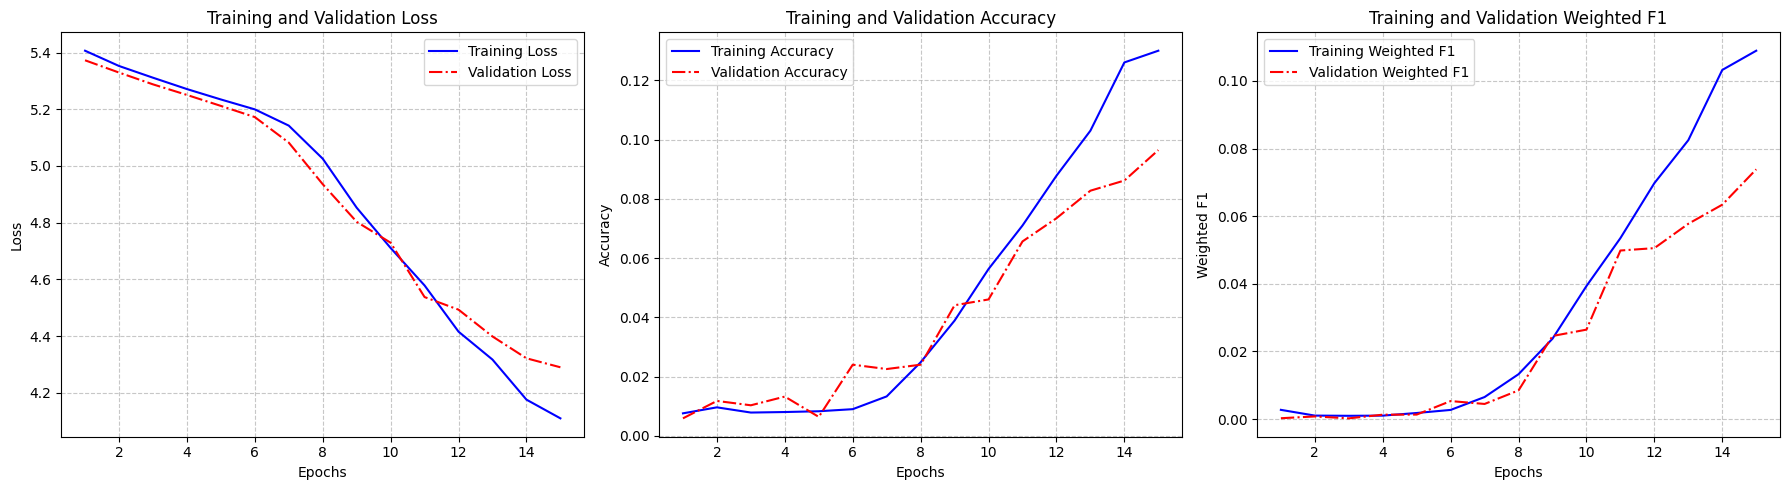

Top-1 accuracy: 0.096, Top-3 accuracy: 0.197, Top-5 accuracy: 0.291, 
Time to calculate: 12.70 seconds
178/178 [==============================] - 117s 657ms/step - loss: 4.1103 - accuracy: 0.1300 - weighted_f1: 0.1089 - macro_f1: 0.1087 - val_loss: 4.2903 - val_accuracy: 0.0965 - val_weighted_f1: 0.0739 - val_macro_f1: 0.0791 - lr: 0.0100


In [ ]:
sgd_optimizer = SGD(lr=0.001, momentum=0.9)
model_with_oversampling, history_with_oversampling = compile_and_train_model(sgd_optimizer, batch_size=64, epochs=15)


In [ ]:
history_data = history_with_oversampling.history

file_path = "/content/history_with_oversampling.pkl"

with open(file_path, "wb") as pickle_file:
    pickle.dump(history_data, pickle_file)

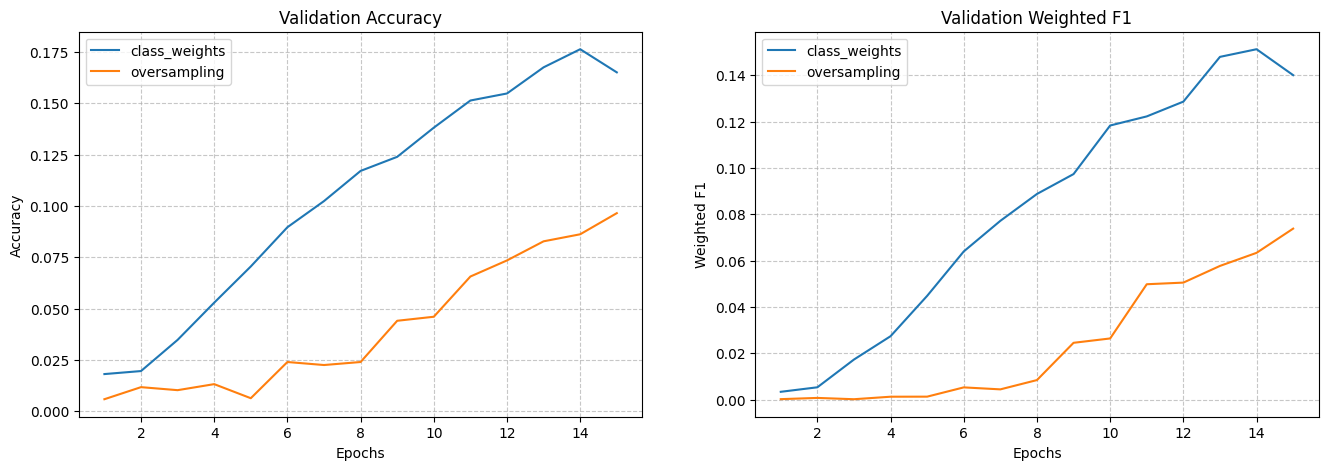

In [ ]:
history = [history_with_class_weights, history_with_oversampling.history]
labels = ['class_weights', 'oversampling']

plot_comparison(history, labels)

#### Let's compare different augmentations

In [ ]:
# strong augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=(0.5, 1.5),
    horizontal_flip=True
)

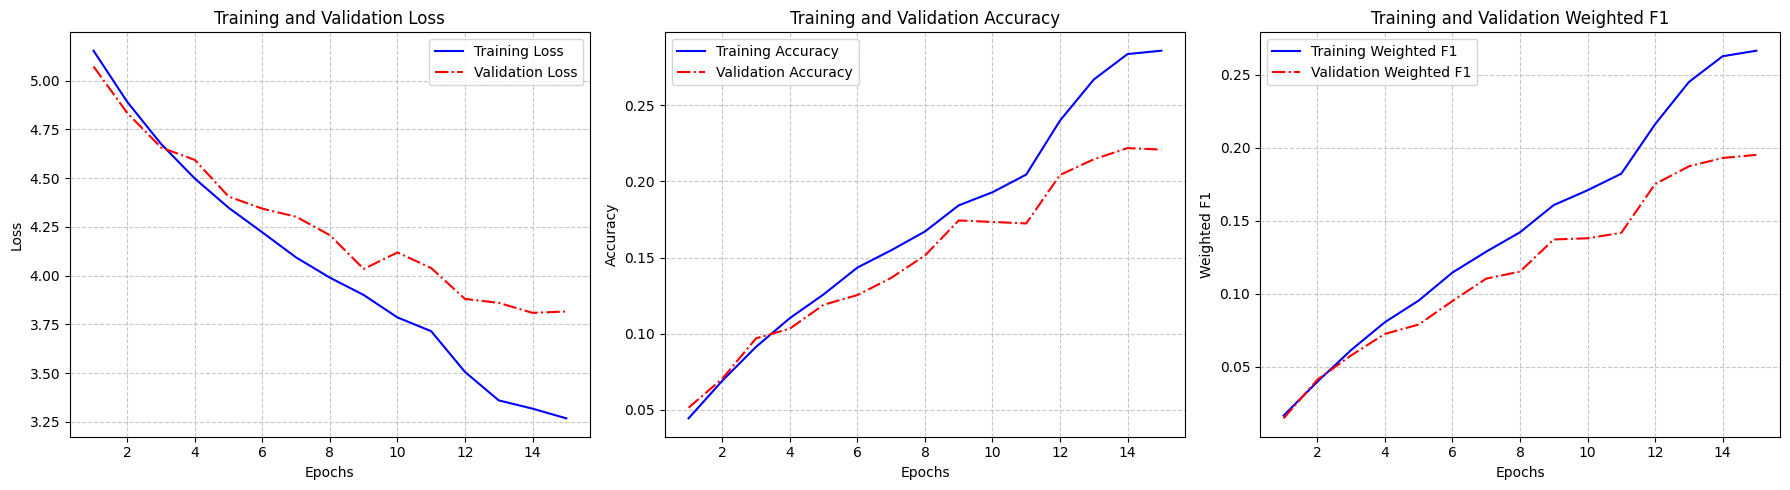

Top-1 accuracy: 0.221, Top-3 accuracy: 0.377, Top-5 accuracy: 0.469, 
Time to calculate: 13.50 seconds
178/178 [==============================] - 125s 700ms/step - loss: 3.2680 - accuracy: 0.2858 - weighted_f1: 0.2666 - macro_f1: 0.2383 - val_loss: 3.8162 - val_accuracy: 0.2209 - val_weighted_f1: 0.1952 - val_macro_f1: 0.1746 - lr: 1.0000e-03


In [ ]:
sgd_optimizer = SGD(lr=0.001, momentum=0.9)
model_strong_datagen, history_strong_datagen = compile_and_train_model(sgd_optimizer, batch_size=64, epochs=15)

In [ ]:
history_data = history_strong_datagen.history

file_path = "/content/history_strong_datagen.pkl"

with open(file_path, "wb") as pickle_file:
    pickle.dump(history_data, pickle_file)

In [ ]:
# medium augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    brightness_range=(0.7, 1.3),
    horizontal_flip=True
)

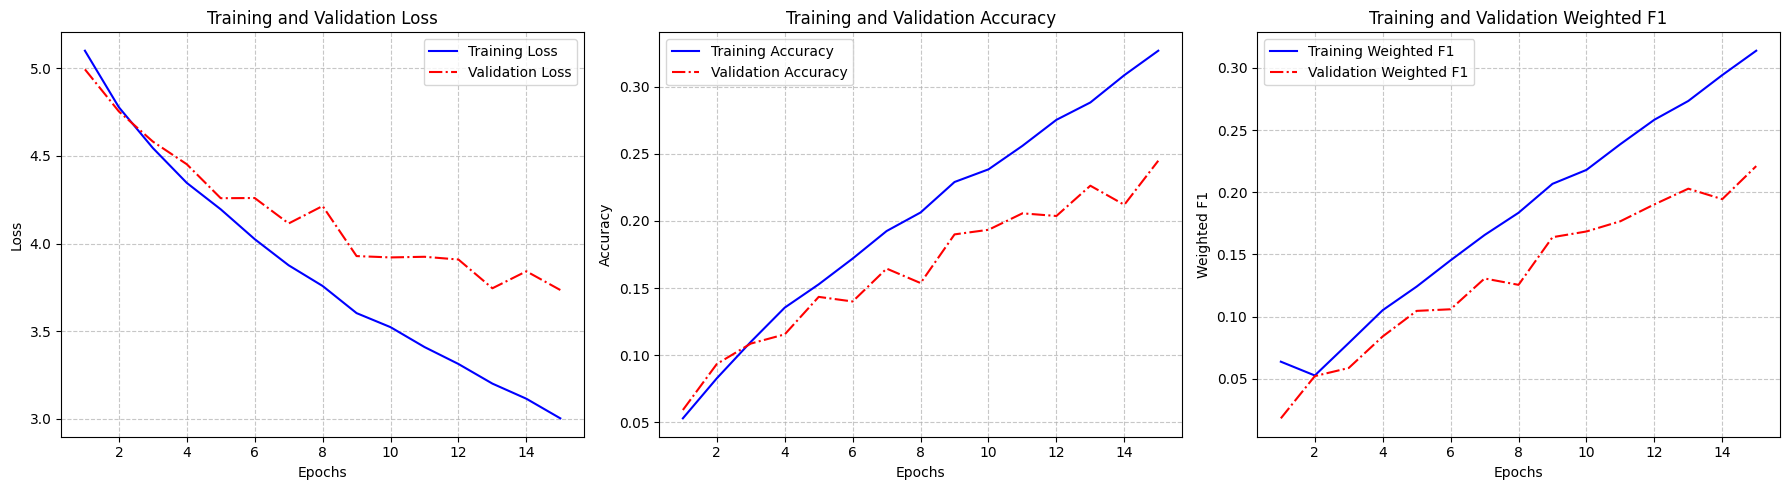

Top-1 accuracy: 0.245, Top-3 accuracy: 0.398, Top-5 accuracy: 0.494, 
Time to calculate: 13.78 seconds
178/178 [==============================] - 125s 701ms/step - loss: 3.0034 - accuracy: 0.3268 - weighted_f1: 0.3138 - macro_f1: 0.2902 - val_loss: 3.7351 - val_accuracy: 0.2449 - val_weighted_f1: 0.2210 - val_macro_f1: 0.2026 - lr: 0.0100


In [ ]:
sgd_optimizer = SGD(lr=0.001, momentum=0.9)
model_medium_datagen, history_medium_datagen = compile_and_train_model(sgd_optimizer, batch_size=64, epochs=15)

In [ ]:
history_data = history_medium_datagen.history

file_path = "/content/history_medium_datagen.pkl"

with open(file_path, "wb") as pickle_file:
    pickle.dump(history_data, pickle_file)

In [ ]:
# weak augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    brightness_range=(0.9, 1.1),
    horizontal_flip=True
)

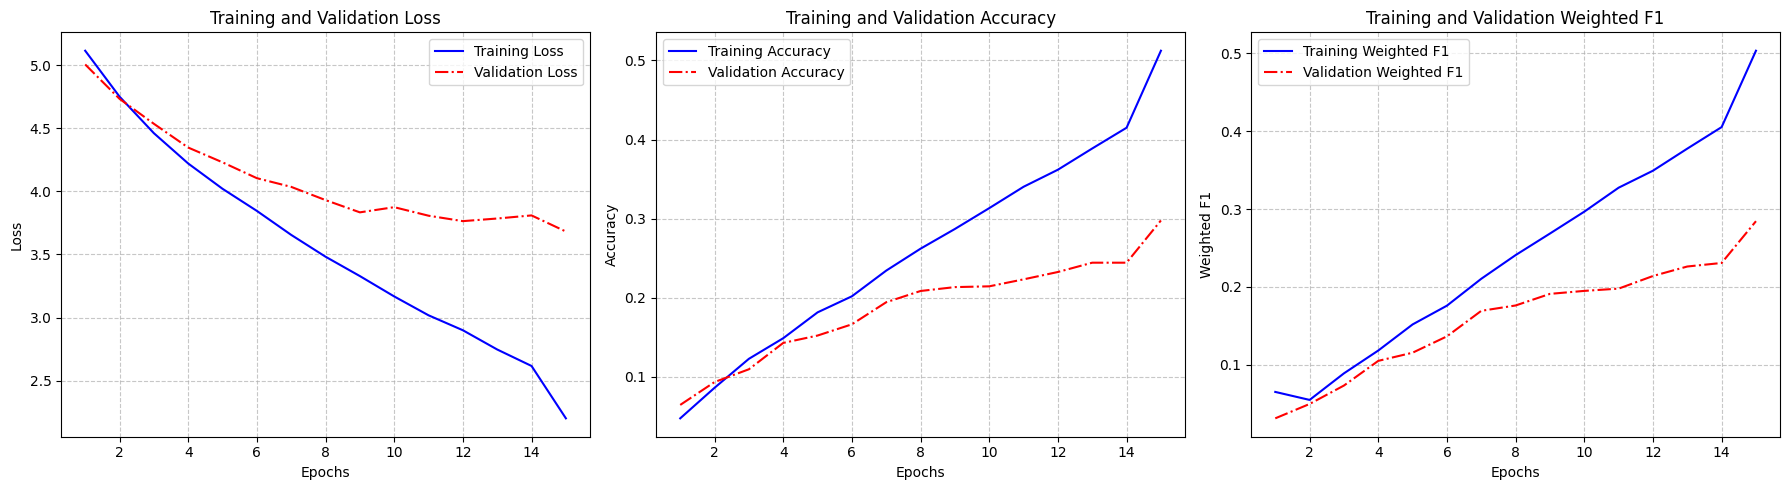

Top-1 accuracy: 0.298, Top-3 accuracy: 0.458, Top-5 accuracy: 0.533, 
Time to calculate: 13.73 seconds
178/178 [==============================] - 122s 688ms/step - loss: 2.1999 - accuracy: 0.5122 - weighted_f1: 0.5035 - macro_f1: 0.4779 - val_loss: 3.6821 - val_accuracy: 0.2977 - val_weighted_f1: 0.2845 - val_macro_f1: 0.2728 - lr: 1.0000e-03


In [ ]:
sgd_optimizer = SGD(lr=0.001, momentum=0.9)
model_weak_datagen, history_weak_datagen = compile_and_train_model(sgd_optimizer, batch_size=64, epochs=15)

In [ ]:
history_data = history_weak_datagen.history

file_path = "/content/history_weak_datagen.pkl"

with open(file_path, "wb") as pickle_file:
    pickle.dump(history_data, pickle_file)

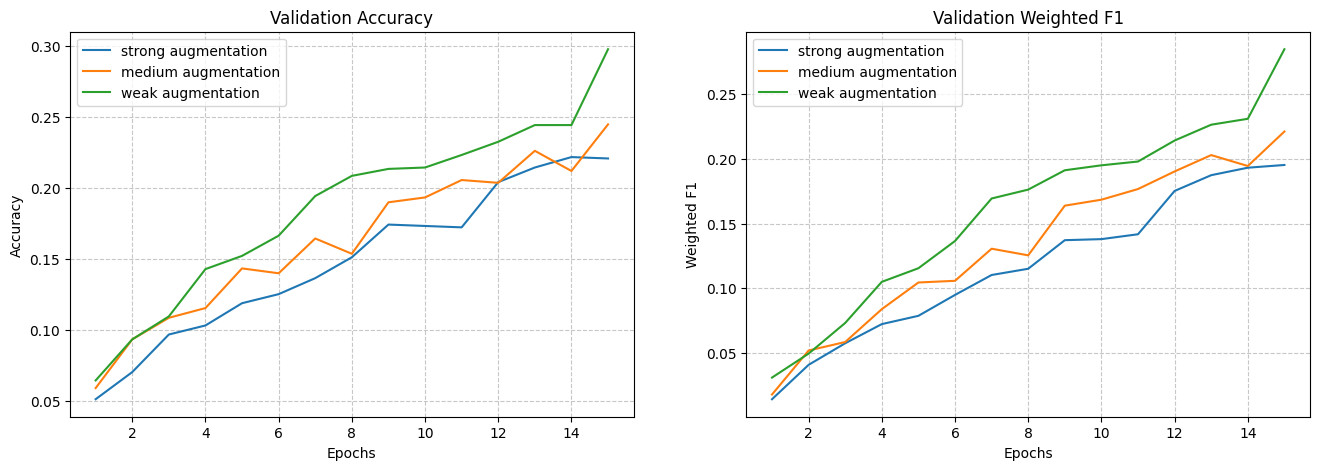

In [ ]:
history = [history_strong_datagen.history, history_medium_datagen.history, history_weak_datagen.history]
labels = ['strong augmentation', 'medium augmentation', 'weak augmentation']

plot_comparison(history, labels)

#### Let's try different architectures

In [ ]:
# We keep weak augmentation for futher modelling
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    brightness_range=(0.9, 1.1),
    horizontal_flip=True
)

We need to modify our function to pass model inside.

In [ ]:
def compile_and_train_model_arch(optimizer, model, batch_size=128, epochs=30, use_class_weights=False, input_size = (128,128)):

    train_generator = train_datagen.flow_from_directory(
        'dataset/train',
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical',
        target_size=input_size)

    val_generator = val_datagen.flow_from_directory(
        'dataset/val',
        batch_size=batch_size,
        class_mode='categorical',
        target_size=input_size)


    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy', weighted_f1_score, macro_f1_score])

    # instance for top_n_accuracy
    top_n_accuracy_callback = TopNAccuracyCallback(val_generator)

    callbacks = [reduce_lr, early_stopping, model_checkpoint, clear_output_callback, plot_metrics_callback, top_n_accuracy_callback]

    if use_class_weights:
        class_weights = dict(enumerate(compute_class_weight('balanced',
                                                            classes=np.unique(train_generator.classes),
                                                            y=train_generator.classes)))
        history = model.fit(train_generator,
                            validation_data=val_generator,
                            epochs=epochs,
                            steps_per_epoch=len(train_generator),
                            validation_steps=len(val_generator),
                            class_weight=class_weights,
                            callbacks=callbacks,
                            verbose=1)
    else:
        history = model.fit(train_generator,
                            validation_data=val_generator,
                            epochs=epochs,
                            steps_per_epoch=len(train_generator),
                            validation_steps=len(val_generator),
                            callbacks=callbacks, verbose=1)

    return model, history

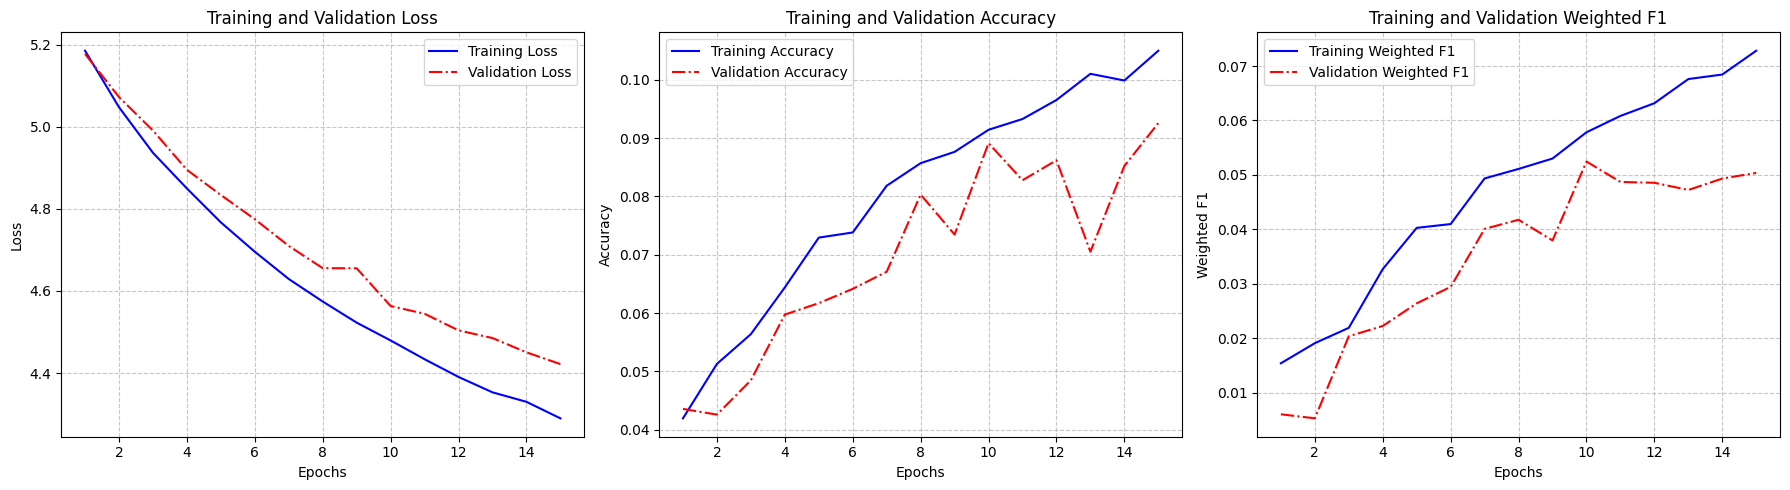

Top-1 accuracy: 0.093, Top-3 accuracy: 0.182, Top-5 accuracy: 0.249, 
Time to calculate: 12.92 seconds
178/178 [==============================] - 114s 639ms/step - loss: 4.2895 - accuracy: 0.1050 - weighted_f1: 0.0728 - macro_f1: 0.0447 - val_loss: 4.4218 - val_accuracy: 0.0926 - val_weighted_f1: 0.0504 - val_macro_f1: 0.0330 - lr: 0.0100


In [ ]:
input_size = (128,128)

# Instance of our pretrained model we will use
base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_size + (3,))
# Make only the top layers of the base model trainable
for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu',
                     kernel_regularizer=l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(114, activation='softmax')
    ])

sgd_optimizer = SGD(lr=0.001, momentum=0.9)
model_transfer_learning_1024, history_transfer_learning_1024 = compile_and_train_model_arch(sgd_optimizer, model, batch_size=64, epochs=15)

In [ ]:
history_data = history_transfer_learning_1024.history

file_path = "/content/history_transfer_learning_1024.pkl"

with open(file_path, "wb") as pickle_file:
    pickle.dump(history_data, pickle_file)

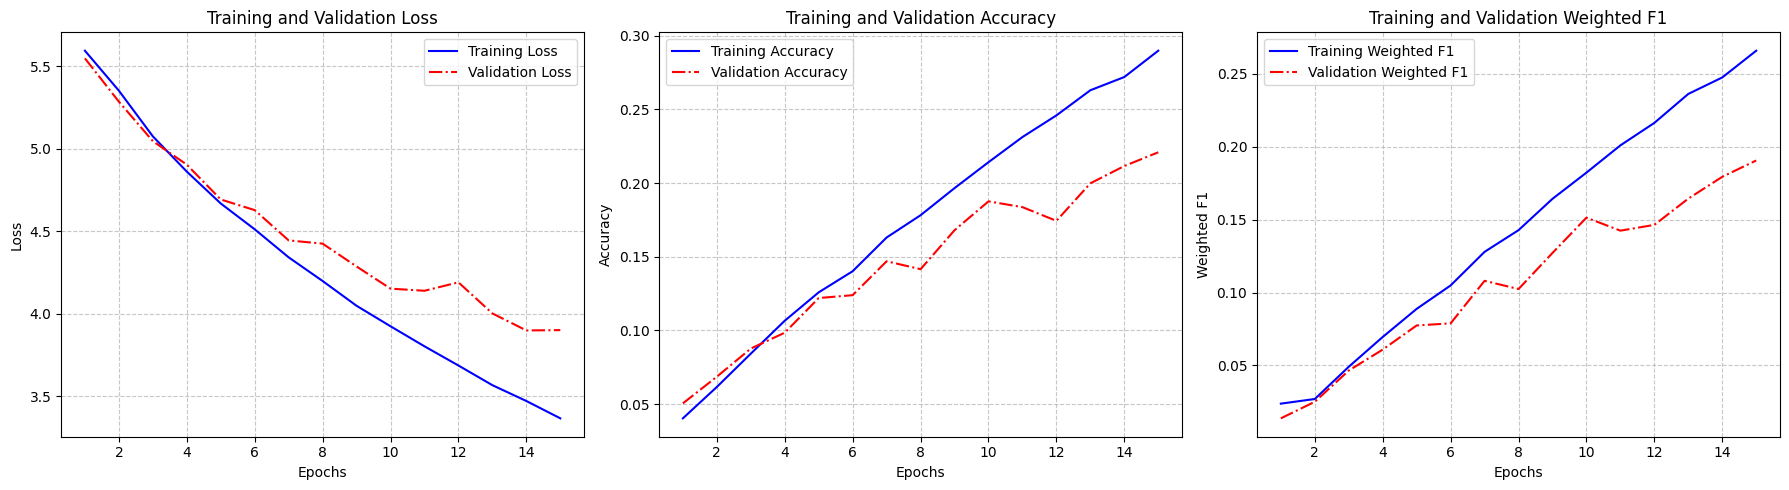

Top-1 accuracy: 0.221, Top-3 accuracy: 0.376, Top-5 accuracy: 0.460, 
Time to calculate: 12.86 seconds
178/178 [==============================] - 115s 646ms/step - loss: 3.3672 - accuracy: 0.2898 - weighted_f1: 0.2660 - macro_f1: 0.2255 - val_loss: 3.9013 - val_accuracy: 0.2209 - val_weighted_f1: 0.1906 - val_macro_f1: 0.1609 - lr: 0.0100


In [ ]:
#same amount of frozen layers but deeper FC part

input_size = (128,128)

# Instance of our pretrained model we will use
base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_size + (3,))
# Make only the top layers of the base model trainable
for layer in base_model.layers[:-4]:
    layer.trainable = False

model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu',
                     kernel_regularizer=l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu',
                     kernel_regularizer=l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(114, activation='softmax')
    ])

sgd_optimizer = SGD(lr=0.001, momentum=0.9)
model_finetune_1024_256, history_finetune_1024_256 = compile_and_train_model_arch(sgd_optimizer, model, batch_size=64, epochs=15)

In [ ]:
history_data = history_finetune_1024_256.history

file_path = "/content/history_finetune_1024_256.pkl"

with open(file_path, "wb") as pickle_file:
    pickle.dump(history_data, pickle_file)

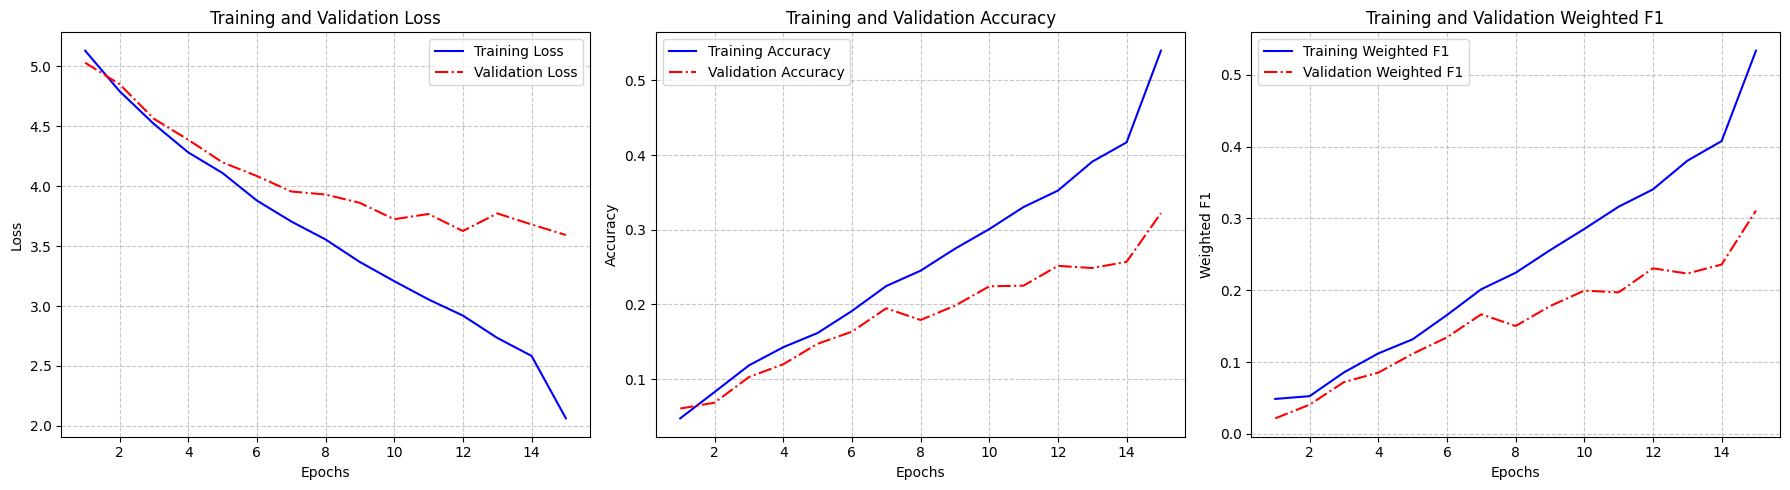

Top-1 accuracy: 0.322, Top-3 accuracy: 0.496, Top-5 accuracy: 0.576, 
Time to calculate: 13.10 seconds
178/178 [==============================] - 117s 655ms/step - loss: 2.0628 - accuracy: 0.5397 - weighted_f1: 0.5337 - macro_f1: 0.5122 - val_loss: 3.5930 - val_accuracy: 0.3222 - val_weighted_f1: 0.3110 - val_macro_f1: 0.2955 - lr: 1.0000e-03


In [ ]:
# Unfreeze more layers but only one Dense layer

input_size = (128,128)

# Instance of our pretrained model we will use
base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_size + (3,))
# Make only the top layers of the base model trainable
for layer in base_model.layers[:-8]:
    layer.trainable = False

model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu',
                     kernel_regularizer=l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(114, activation='softmax')
    ])

sgd_optimizer = SGD(lr=0.001, momentum=0.9)
model_finetune_1024_8, history_finetune_1024_8 = compile_and_train_model_arch(sgd_optimizer, model, batch_size=64, epochs=15)

In [ ]:
history_data = history_finetune_1024_8.history

file_path = "/content/history_finetune_1024_8.pkl"

with open(file_path, "wb") as pickle_file:
    pickle.dump(history_data, pickle_file)

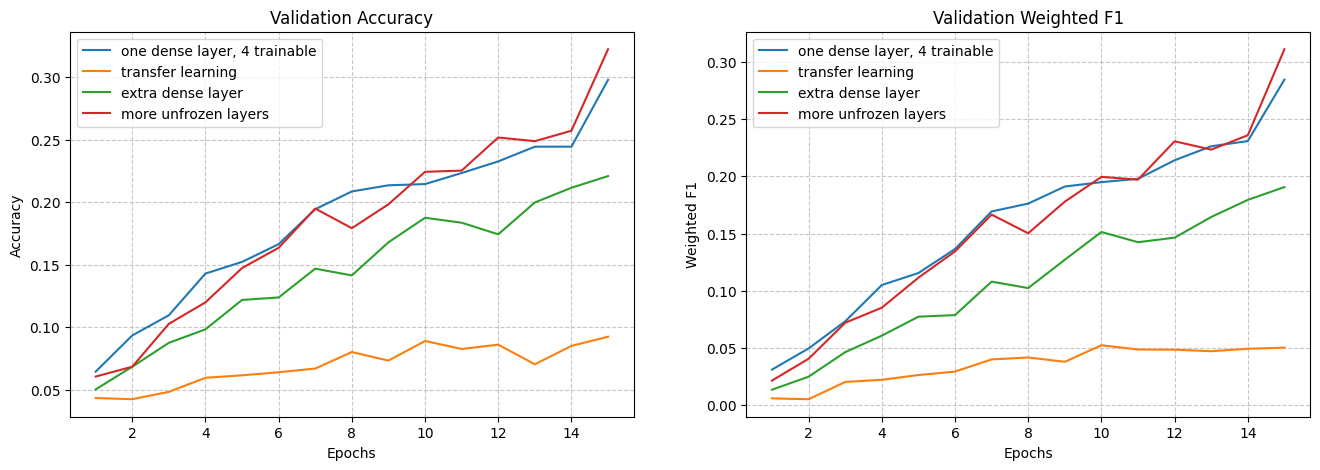

In [ ]:
history = [standard_model_history, history_transfer_learning_1024.history, history_finetune_1024_256.history, history_finetune_1024_8.history]
labels = ['one dense layer, 4 trainable', 'transfer learning', 'extra dense layer', 'more unfrozen layers']

plot_comparison(history, labels)

#### Training best model for 30 epochs

In [ ]:
def compile_and_train_model_arch(optimizer, model, batch_size=128, epochs=30, use_class_weights=False, input_size = (128,128)):

    train_generator = train_datagen.flow_from_directory(
        'dataset/train',
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical',
        target_size=input_size)

    val_generator = val_datagen.flow_from_directory(
        'dataset/val',
        batch_size=batch_size,
        class_mode='categorical',
        target_size=input_size)


    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy', weighted_f1_score, macro_f1_score])

    # instance for top_n_accuracy
    top_n_accuracy_callback = TopNAccuracyCallback(val_generator)

    callbacks = [reduce_lr, early_stopping, model_checkpoint, clear_output_callback, plot_metrics_callback, top_n_accuracy_callback]

    if use_class_weights:
        class_weights = dict(enumerate(compute_class_weight('balanced',
                                                            classes=np.unique(train_generator.classes),
                                                            y=train_generator.classes)))
        history = model.fit(train_generator,
                            validation_data=val_generator,
                            epochs=epochs,
                            steps_per_epoch=len(train_generator),
                            validation_steps=len(val_generator),
                            class_weight=class_weights,
                            callbacks=callbacks,
                            verbose=1)
    else:
        history = model.fit(train_generator,
                            validation_data=val_generator,
                            epochs=epochs,
                            steps_per_epoch=len(train_generator),
                            validation_steps=len(val_generator),
                            callbacks=callbacks, verbose=1)

    return model, history

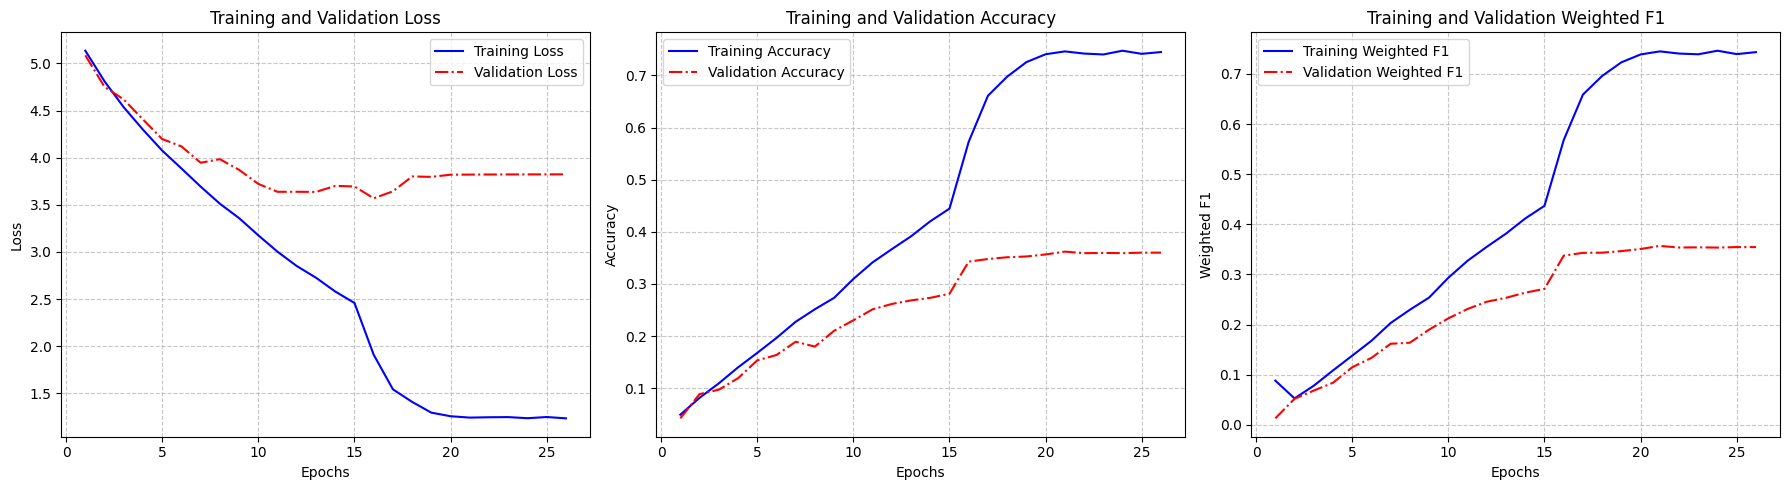

Top-1 accuracy: 0.362, Top-3 accuracy: 0.513, Top-5 accuracy: 0.598, 
Time to calculate: 13.06 seconds
178/178 [==============================] - 120s 676ms/step - loss: 1.2339 - accuracy: 0.7448 - weighted_f1: 0.7433 - macro_f1: 0.7276 - val_loss: 3.8230 - val_accuracy: 0.3599 - val_weighted_f1: 0.3546 - val_macro_f1: 0.3439 - lr: 1.0000e-06


In [ ]:
# We keep weak augmentation for futher modelling
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    brightness_range=(0.9, 1.1),
    horizontal_flip=True
)

input_size = (128,128)

# Instance of our pretrained model we will use
base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_size + (3,))

# Make only the top layers of the base model trainable
for layer in base_model.layers[:-8]:
    layer.trainable = False

model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu',
                     kernel_regularizer=l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(114, activation='softmax')
    ])

sgd_optimizer = SGD(lr=0.001, momentum=0.9)
model_best, history_best = compile_and_train_model_arch(sgd_optimizer, model, batch_size=64, epochs=30)

In [ ]:
history_data = history_best.history

file_path = "/content/history_best1.pkl"

with open(file_path, "wb") as pickle_file:
    pickle.dump(history_data, pickle_file)

In [ ]:
model_best.save_weights('model_best_weights1.h5')